# Tutorial 6: Simple Surface Processes

In [1]:
import UWGeodynamics as GEO

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

In [3]:
# Characteristic values of the system
half_rate = 1.8 * u.centimeter / u.year
model_length = 360e3 * u.meter
model_height = 120e3 * u.meter
refViscosity = 1e24 * u.pascal * u.second
surfaceTemp = 273.15 * u.degK
baseModelTemp = 1603.15 * u.degK
bodyforce = 3300 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2

KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

In [4]:
Model = GEO.Model(elementRes=(180, 60), 
                  minCoord=(0. * u.kilometer, -110. * u.kilometer), 
                  maxCoord=(360. * u.kilometer, 10. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
Model.outputDir="outputs_tutorial6"

In [6]:
Model.diffusivity = 1e-6 * u.metre**2 / u.second 
Model.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

In [7]:
air               = Model.add_material(name="Air", shape=GEO.shapes.Layer2D(top=Model.top, bottom=2.0 * u.kilometer))
stickyAir         = Model.add_material(name="StickyAir", shape=GEO.shapes.Layer2D(top=air.bottom, bottom= 0.0 * u.kilometer))
uppercrust        = Model.add_material(name="UppperCrust", shape=GEO.shapes.Layer2D(top=stickyAir.bottom, bottom=-35.0 * u.kilometer))
mantleLithosphere = Model.add_material(name="MantleLithosphere", shape=GEO.shapes.Layer2D(top=uppercrust.bottom, bottom=-100.0 * u.kilometer))
mantle            = Model.add_material(name="Mantle", shape=GEO.shapes.Layer2D(top=mantleLithosphere.bottom, bottom=Model.bottom))
sediment          = Model.add_material(name="Sediment")

In [8]:
air.diffusivity = 1.0e-6 * u.metre**2 / u.second
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

stickyAir.diffusivity = 1.0e-6 * u.metre**2 / u.second
stickyAir.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [9]:
air.density                = 1. * u.kilogram / u.metre**3
stickyAir.density          = 1. * u.kilogram / u.metre**3
uppercrust.density         = GEO.LinearDensity(reference_density=2620. * u.kilogram / u.metre**3)
mantleLithosphere.density  = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
mantle.density             = GEO.LinearDensity(reference_density=3370. * u.kilogram / u.metre**3)
sediment.density           = GEO.LinearDensity(reference_density=2300. * u.kilogram / u.metre**3)

In [10]:
uppercrust.radiogenicHeatProd = 0.7 * u.microwatt / u.meter**3
sediment.radiogenicHeatProd   = 0.7 * u.microwatt / u.meter**3
mantleLithosphere.radiogenicHeatProd = 0.02e-6 * u.microwatt / u.meter**3

In [11]:
rh = GEO.ViscousCreepRegistry()

In [12]:
air.viscosity                = 1e19 * u.pascal * u.second
stickyAir.viscosity          = 1e20 * u.pascal * u.second
uppercrust.viscosity         = 30 * rh.Gleason_and_Tullis_1995
mantleLithosphere.viscosity  = 5 * rh.Karato_and_Wu_1990
mantle.viscosity             = rh.Karato_and_Wu_1990
sediment.viscosity         = rh.Gleason_and_Tullis_1995

In [13]:
plasticity = GEO.DruckerPrager(cohesion=20.0 * u.megapascal,
                               cohesionAfterSoftening=20 * u.megapascal,
                               frictionCoefficient=0.12,
                               frictionAfterSoftening=0.02,
                               epsilon1=0.5,
                               epsilon2=1.5)

In [14]:
uppercrust.plasticity         = plasticity
mantleLithosphere.plasticity  = plasticity
mantle.plasticity             = plasticity
sediment.plasticity           = plasticity

## Temperature Boundary Condition

In [15]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=1603.15 * u.degK, 
                         materials=[(mantle, 1603.15 * u.degK), (air, 293.15 * u.degK), (stickyAir, 293.15 * u.degK)])

## Velocity Boundary Conditions

In [16]:
Model.set_velocityBCs(left=[-2.5 * u.centimeter / u.year, None],
                       right=[2.5 * u.centimeter / u.year, None],
                       bottom=GEO.LecodeIsostasy(reference_mat=mantle.index, average=True))

## Initial Damage

In [17]:
import numpy as np

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.7
Model.plasticStrain.data[:] = maxDamage * np.random.rand(*Model.plasticStrain.data.shape[:])
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], (GEO.nd(Model.maxCoord[0] - Model.minCoord[0])) / 2.0, GEO.nd(5.0 * u.kilometer))
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,1], GEO.nd(-35. * u.kilometer) , GEO.nd(5.0 * u.kilometer))

In [18]:
Model.surfaceProcesses = GEO.surfaceProcesses.SedimentationThreshold(Model.swarm, Model.materialField, air=[air, stickyAir], sediment=[sediment], threshold=0.)


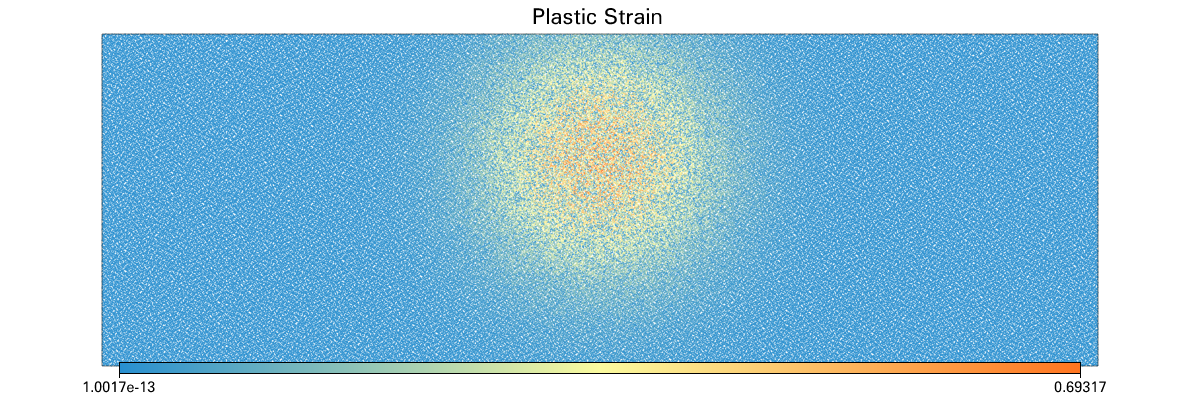

In [19]:
Fig = Model.plot.plastic_strain(figsize=(1200,400), fn_size=2.)


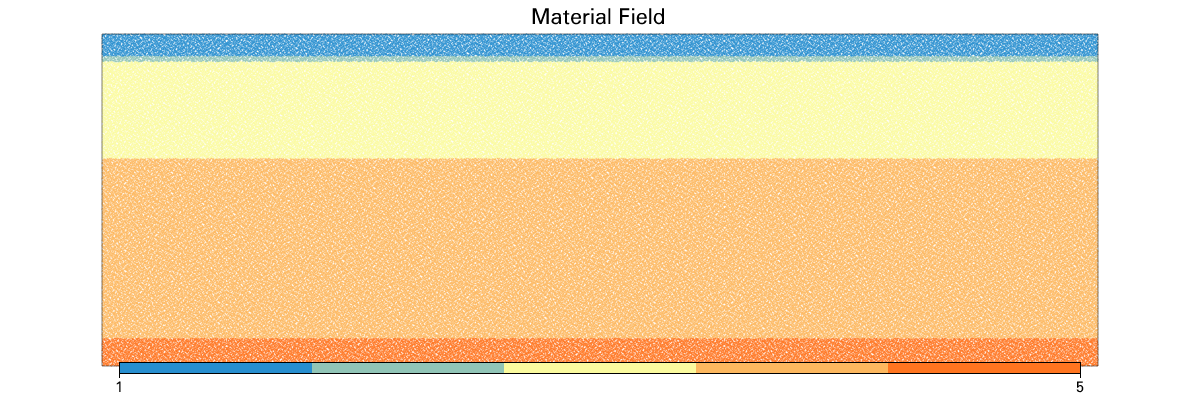

In [20]:
Fig = Model.plot.material(figsize=(1200,400), fn_size=2.)

In [21]:
Model.init_model()


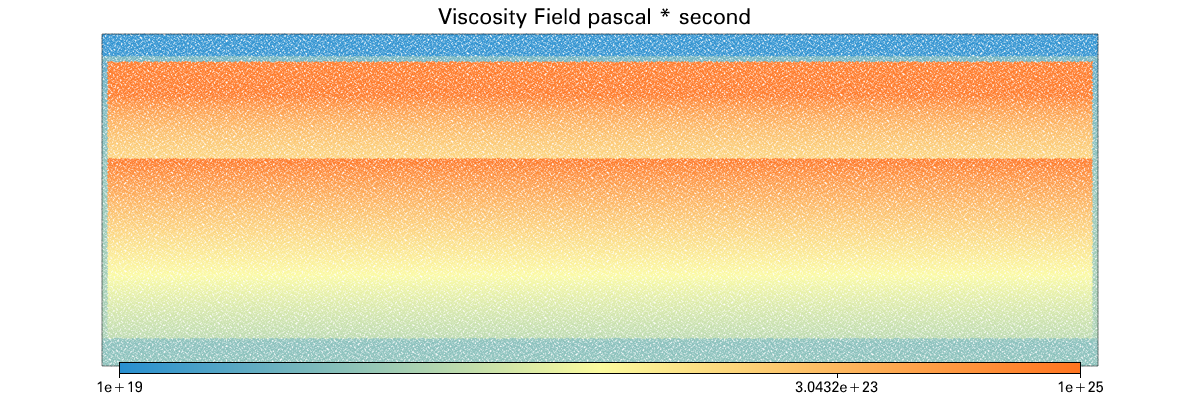

In [22]:
Fig = Model.plot.viscosity(figsize=(1200,400), fn_size=2.)

In [23]:
Model.run_for(3.0 * u.megayear)

Time:  0.00796981629704 megayear dt: 0.00796981629704 megayear
Time:  0.0166457406287 megayear dt: 0.00867592433166 megayear
Time:  0.025322182059 megayear dt: 0.00867644143035 megayear
Time:  0.0339987065139 megayear dt: 0.00867652445486 megayear
Time:  0.042675701178 megayear dt: 0.00867699466408 megayear
Time:  0.0513528487592 megayear dt: 0.00867714758116 megayear
Time:  0.0600297360693 megayear dt: 0.00867688731015 megayear
Time:  0.0687068495927 megayear dt: 0.00867711352338 megayear
Time:  0.0773835424665 megayear dt: 0.00867669287381 megayear
Time:  0.0860601997906 megayear dt: 0.0086766573241 megayear
Time:  0.094737317507 megayear dt: 0.00867711771639 megayear
Time:  0.103414542423 megayear dt: 0.00867722491575 megayear
Time:  0.11209166059 megayear dt: 0.00867711816701 megayear
Time:  0.12076862192 megayear dt: 0.00867696133027 megayear
Time:  0.129445509018 megayear dt: 0.00867688709759 megayear
Time:  0.138122307341 megayear dt: 0.00867679832339 megayear
Time:  0.146798838

Time:  1.17852031009 megayear dt: 0.00866195564165 megayear
Time:  1.18718171382 megayear dt: 0.00866140372558 megayear
Time:  1.19584284057 megayear dt: 0.00866112675524 megayear
Time:  1.20450402745 megayear dt: 0.008661186879 megayear
Time:  1.21316487833 megayear dt: 0.00866085087618 megayear
Time:  1.22182504517 megayear dt: 0.0086601668416 megayear
Time:  1.23048511022 megayear dt: 0.00866006505256 megayear
Time:  1.23914538481 megayear dt: 0.00866027458939 megayear
Time:  1.24780582606 megayear dt: 0.00866044124665 megayear
Time:  1.25646617815 megayear dt: 0.00866035209639 megayear
Time:  1.2651268102 megayear dt: 0.00866063204755 megayear
Time:  1.27378789976 megayear dt: 0.00866108955591 megayear
Time:  1.28244879225 megayear dt: 0.00866089248989 megayear
Time:  1.29111034043 megayear dt: 0.00866154818045 megayear
Time:  1.29977130837 megayear dt: 0.00866096794548 megayear
Time:  1.30843130949 megayear dt: 0.00866000112031 megayear
Time:  1.31709062093 megayear dt: 0.00865931

Time:  2.36417561142 megayear dt: 0.0086390514408 megayear
Time:  2.3728119018 megayear dt: 0.00863629038651 megayear
Time:  2.38144973984 megayear dt: 0.00863783803973 megayear
Time:  2.39008726397 megayear dt: 0.00863752412818 megayear
Time:  2.39872540372 megayear dt: 0.00863813974436 megayear
Time:  2.40736323781 megayear dt: 0.00863783409973 megayear
Time:  2.41600111246 megayear dt: 0.00863787464336 megayear
Time:  2.42463886974 megayear dt: 0.00863775727864 megayear
Time:  2.4332777329 megayear dt: 0.008638863167 megayear
Time:  2.44191520126 megayear dt: 0.00863746835126 megayear
Time:  2.45055241618 megayear dt: 0.00863721492257 megayear
Time:  2.45918550125 megayear dt: 0.00863308506803 megayear
Time:  2.46782138347 megayear dt: 0.00863588222607 megayear
Time:  2.47645588042 megayear dt: 0.00863449694894 megayear
Time:  2.48508996964 megayear dt: 0.00863408922294 megayear
Time:  2.49372334355 megayear dt: 0.00863337390542 megayear
Time:  2.50235810406 megayear dt: 0.008634760

1


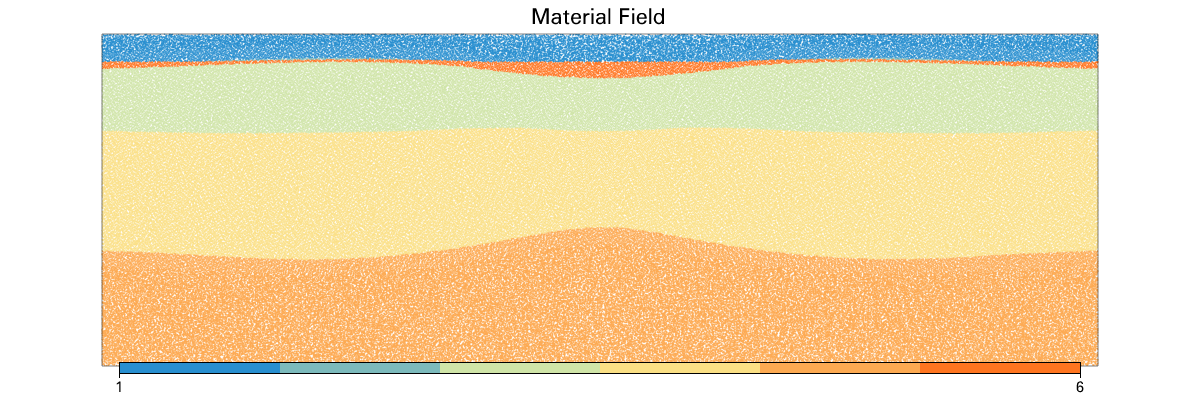

In [24]:
Fig = Model.plot.material(onMesh=False, figsize=(1200,400), fn_size=2.)